In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
import os
import joblib
import lingam
import re
import warnings

from graphviz import Digraph
from lingam.utils import make_dot
from IPython.display import Image, display, Markdown
from pyvis.network import Network
from IPython.display import display
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime


warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")




# Configuration
FORECAST_HORIZONS = [7, 14, 30]
TEST_SIZE_DAYS = 30  # Last 30 days for testing
RANDOM_STATE = 42
MODEL_DIR = '../models/xgboost_baseline'


# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

print("✓ Imports complete")
print(f"XGBoost version: {xgb.__version__}")
print(f"Forecast Horizons: {FORECAST_HORIZONS} days")
print(f"Model directory: {MODEL_DIR}")

✓ Imports complete
XGBoost version: 3.1.2
Forecast Horizons: [7, 14, 30] days
Model directory: ../models/xgboost_baseline


<br> <br>

## 1. Loading Data

In [2]:

# Edges
df_edges_plant = pd.read_csv("../data/SupplyGraph/Edges/Edges (Plant).csv")
df_edges_product_group = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Group).csv")
df_edges_product_subgroup = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Sub-Group).csv")
df_edges_storage_location = pd.read_csv("../data/SupplyGraph/Edges/Edges (Storage Location).csv")

# Nodes
df_nodes_productgroup_and_subgroup = pd.read_csv("../data/SupplyGraph/Nodes/Node Types (Product Group and Subgroup).csv")
df_nodes_plant_and_storage = pd.read_csv("../data/SupplyGraph/Nodes/Nodes Type (Plant & Storage).csv")
df_nodes = pd.read_csv("../data/SupplyGraph/Nodes/Nodes.csv")
# df_nodes_index = pd.read_csv("../data/SupplyGraph/Nodes/NodesIndex.csv")

# Temporal
df_temporal_delivery_to_distributor = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Delivery To distributor.csv")
df_temporal_factory_issue = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Factory Issue.csv")
df_temporal_production = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Production.csv")
df_temporal_sales_order = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Sales Order.csv")

In [3]:
df_temporal_sales_order['Date'] = pd.to_datetime(df_temporal_sales_order['Date'])
df_temporal_sales_order_pivot = df_temporal_sales_order.melt(id_vars='Date', var_name='Product', value_name='Sales').dropna()

df_temporal_production['Date'] = pd.to_datetime(df_temporal_production['Date'])
df_temporal_production_pivot = df_temporal_production.melt(id_vars='Date', var_name='Product', value_name='Production Quantity').dropna()

df_temporal_factory_issue['Date'] = pd.to_datetime(df_temporal_factory_issue['Date'])
df_temporal_factory_issue_pivot = df_temporal_factory_issue.melt(id_vars='Date', var_name='Product', value_name='Factory Issue').dropna()

df_temporal_delivery_to_distributor['Date'] = pd.to_datetime(df_temporal_delivery_to_distributor['Date'])
df_temporal_delivery_to_distributor_pivot = df_temporal_delivery_to_distributor.melt(id_vars='Date', var_name='Product', value_name='Distributor').dropna()

<br> <br>

## 2. Calculate Coefficient of Variation (CV)

In [4]:
def calculate_product_stats(df, group_col='Product', agg_col='Sales'):
    stats = (
        df.groupby(group_col)
          .agg(
              total_units=(agg_col, 'sum'),
              days_with_activity=(agg_col, lambda x: (x > 0).sum()),
              num_days=(agg_col, 'count'),
              avg_daily=(agg_col, 'mean'),
              std_daily=(agg_col, 'std')
          )
    )
    
    stats['activity_frequency'] = stats['days_with_activity'] / stats['num_days']    
    stats['cv'] = stats['std_daily'] / stats['avg_daily']
    # stats['cv'] = stats['cv'].replace([np.inf, -np.inf], np.nan)
    
    # Reset index to make group_col a regular column
    stats = stats.reset_index()
    
    return stats


display(Markdown("""
**Coefficient of Variation (CV) = Standard Deviation / Mean**
### What it means:
- **CV measures relative variability** of sales (or any metric) compared to the average
- It's a **normalized measure of dispersion** - unitless and comparable across products with different scales

### Interpretation:
- **Low CV (< 0.5)** => `Stable/predictable` demand - sales are consistent day-to-day
- **Medium CV (0.5 - 1.0)** => `Moderate variability` - some fluctuation but manageable
- **High CV (> 1.0)** => `Highly volatile/erratic` demand - unpredictable sales patterns
"""
))


print("\n\n")


# Example usage for all temporal dataframes:

# Sales statistics
sales_stats = calculate_product_stats(df_temporal_sales_order_pivot, group_col='Product', agg_col='Sales')
display(Markdown("**Sales Statistics**"))
display(sales_stats)

# # Production statistics
production_stats = calculate_product_stats(df_temporal_production_pivot, group_col='Product', agg_col='Production Quantity')
display(Markdown("**Production Statistics**"))
display(production_stats)

# # Factory Issue statistics
factory_issue_stats = calculate_product_stats(df_temporal_factory_issue_pivot, group_col='Product', agg_col='Factory Issue')
display(Markdown("**Factory Issue Statistics**"))
display(factory_issue_stats)

# # Delivery statistics
delivery_stats = calculate_product_stats(df_temporal_delivery_to_distributor_pivot, group_col='Product', agg_col='Distributor')
display(Markdown("**Delivery Statistics**"))
display(delivery_stats)


**Coefficient of Variation (CV) = Standard Deviation / Mean**
### What it means:
- **CV measures relative variability** of sales (or any metric) compared to the average
- It's a **normalized measure of dispersion** - unitless and comparable across products with different scales

### Interpretation:
- **Low CV (< 0.5)** => `Stable/predictable` demand - sales are consistent day-to-day
- **Medium CV (0.5 - 1.0)** => `Moderate variability` - some fluctuation but manageable
- **High CV (> 1.0)** => `Highly volatile/erratic` demand - unpredictable sales patterns


**Sales Statistics**

,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv
0,AT5X5K,1.782512e+05,174,221,806.566516,938.839092,0.787330,1.163995
1,ATN01K24P,6.393748e+05,179,221,2893.098569,2701.549761,0.809955,0.933791
2,ATN02K12P,1.370076e+05,177,221,619.943831,615.530467,0.800905,0.992881
3,ATPA1K24P,3.100000e+01,1,221,0.140271,2.085286,0.004525,14.866069
4,ATPPCH5X5K,1.000000e+01,1,221,0.045249,0.672673,0.004525,14.866069
5,ATWWP001K24P,9.223728e+03,159,221,41.736327,52.292598,0.719457,1.252928
6,ATWWP002K12P,3.733000e+03,125,221,16.891401,39.055150,0.565611,2.312132
7,EEA200G24P,5.000000e+00,1,221,0.022624,0.336336,0.004525,14.866069
8,EEA500G12P,1.150000e+02,3,221,0.520362,5.250610,0.013575,10.090302
9,MAC1K25P,8.880000e+02,30,221,4.018100,14.922212,0.135747,3.713749


**Production Statistics**

,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv
0,AT5X5K,174364,159,221,788.977376,775.403528,0.719457,0.982796
1,ATN01K24P,616229,189,221,2788.366516,1998.634351,0.855204,0.716776
2,ATN02K12P,128748,163,221,582.570136,526.390480,0.737557,0.903566
3,ATPA1K24P,0,0,221,0.000000,0.000000,0.000000,NaN
4,ATPPCH5X5K,0,0,221,0.000000,0.000000,0.000000,NaN
5,ATWWP001K24P,9587,9,221,43.380090,245.014509,0.040724,5.648087
6,ATWWP002K12P,2663,7,221,12.049774,81.261040,0.031674,6.743781
7,EEA200G24P,0,0,221,0.000000,0.000000,0.000000,NaN
8,EEA500G12P,0,0,221,0.000000,0.000000,0.000000,NaN
9,MAC1K25P,932,18,221,4.217195,20.196486,0.081448,4.789081


**Factory Issue Statistics**

,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv
0,AT5X5K,174998.000,197,221,791.846154,731.571921,0.891403,0.923881
1,ATN01K24P,623501.452,204,221,2821.273538,1916.326122,0.923077,0.679242
2,ATN02K12P,128222.500,199,221,580.192308,467.921483,0.900452,0.806494
3,ATPA1K24P,0.000,0,221,0.000000,0.000000,0.000000,NaN
4,ATPPCH5X5K,0.000,0,221,0.000000,0.000000,0.000000,NaN
5,ATWWP001K24P,9796.000,102,221,44.325792,174.563332,0.461538,3.938189
6,ATWWP002K12P,2527.416,55,221,11.436271,27.725026,0.248869,2.424306
7,EEA200G24P,0.000,0,221,0.000000,0.000000,0.000000,NaN
8,EEA500G12P,0.000,0,221,0.000000,0.000000,0.000000,NaN
9,MAC1K25P,843.000,19,221,3.814480,17.630216,0.085973,4.621919


**Delivery Statistics**

,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv
0,AT5X5K,1.804521e+05,213,221,816.525520,672.531911,0.963801,0.823651
1,ATN01K24P,6.363128e+05,213,221,2879.243267,1704.033011,0.963801,0.591834
2,ATN02K12P,1.332964e+05,213,221,603.151300,405.201518,0.963801,0.671807
3,ATPA1K24P,0.000000e+00,0,221,0.000000,0.000000,0.000000,NaN
4,ATPPCH5X5K,0.000000e+00,0,221,0.000000,0.000000,0.000000,NaN
5,ATWWP001K24P,9.391247e+03,177,221,42.494329,45.717782,0.800905,1.075856
6,ATWWP002K12P,2.652329e+03,119,221,12.001487,19.963806,0.538462,1.663444
7,EEA200G24P,6.210417e-01,1,221,0.002810,0.041776,0.004525,14.866069
8,EEA500G12P,0.000000e+00,0,221,0.000000,0.000000,0.000000,NaN
9,MAC1K25P,8.720000e+02,32,221,3.945701,14.241002,0.144796,3.609245


## 2 – Label fast/medium/slow

In [5]:
def classify_speed_segment(stats_df, volume_col='total_units', frequency_col='activity_frequency',  q_high=0.8, q_mid=0.5, freq_threshold=0.5):
    
    df = stats_df.copy()
    
    # Calculate quantiles
    q80 = df[volume_col].quantile(q_high) # e.g. 153888.006 = this value changes based on stats_df
    q50 = df[volume_col].quantile(q_mid)  # e.g. 36836.0001 = this value changes based on stats_df
    print(f"q80 = {q80}")
    print(f"q50 = {q50}")
    print(f"Volume Column is: {volume_col}")
    print(f"if ({volume_col} >= {q80}) and ({frequency_col} >= {freq_threshold}) => `Fast`\nelif {volume_col} >= {q50} => `Medium`\nelse => `Slow`")
    print("\n\n")

    # Classification function
    def classify(row):
        if row[volume_col] >= q80 and row[frequency_col] > freq_threshold: # if total_unit > 153888.006 and "activity_frequency (0.7873)" > 0.4 (0.5=default value) 
            return 'Fast'
        elif row[volume_col] >= q50:
            return 'Medium'
        else:
            return 'Slow'
    
    # Apply classification
    df['speed_segment'] = df.apply(classify, axis=1)
    
    return df



# Classify sales statistics
df_stats_classified = classify_speed_segment(
    sales_stats, 
    volume_col='total_units',
    q_high=0.75,  # Top 25% instead of 20%
    q_mid=0.5,
    freq_threshold=0.4  # Lower frequency threshold
)

# Classify production statistics
# df_stats_classified = classify_speed_segment(
#     production_stats, 
#     volume_col='total_units',
#     q_high=0.75,  # Top 25% instead of 20%
#     q_mid=0.5,
#     freq_threshold=0.4  # Lower frequency threshold
# )

# # Classify factory issue statistics
# df_stats_classified = classify_speed_segment(
#     factory_issue_stats, 
#     volume_col='total_units',
#     q_high=0.75,  # Top 25% instead of 20%
#     q_mid=0.5,
#     freq_threshold=0.4  # Lower frequency threshold
# )

# Classify delivery statistics
# df_stats_classified = classify_speed_segment(
#     delivery_stats, 
#     volume_col='total_units',
#     q_high=0.75,  # Top 25% instead of 20%
#     q_mid=0.5,
#     freq_threshold=0.4  # Lower frequency threshold
# )

# display(sales_stats)
display(df_stats_classified)

q80 = 153888.006
q50 = 36836.00000000001
Volume Column is: total_units
if (total_units >= 153888.006) and (activity_frequency >= 0.4) => `Fast`
elif total_units >= 36836.00000000001 => `Medium`
else => `Slow`





,Product,total_units,days_with_activity,num_days,avg_daily,std_daily,activity_frequency,cv,speed_segment
0,AT5X5K,1.782512e+05,174,221,806.566516,938.839092,0.787330,1.163995,Fast
1,ATN01K24P,6.393748e+05,179,221,2893.098569,2701.549761,0.809955,0.933791,Fast
2,ATN02K12P,1.370076e+05,177,221,619.943831,615.530467,0.800905,0.992881,Medium
3,ATPA1K24P,3.100000e+01,1,221,0.140271,2.085286,0.004525,14.866069,Slow
4,ATPPCH5X5K,1.000000e+01,1,221,0.045249,0.672673,0.004525,14.866069,Slow
5,ATWWP001K24P,9.223728e+03,159,221,41.736327,52.292598,0.719457,1.252928,Slow
6,ATWWP002K12P,3.733000e+03,125,221,16.891401,39.055150,0.565611,2.312132,Slow
7,EEA200G24P,5.000000e+00,1,221,0.022624,0.336336,0.004525,14.866069,Slow
8,EEA500G12P,1.150000e+02,3,221,0.520362,5.250610,0.013575,10.090302,Slow
9,MAC1K25P,8.880000e+02,30,221,4.018100,14.922212,0.135747,3.713749,Slow



<br> <br> <br>

### 2.1 – Identify Fast Movers

In [6]:
all_fast = df_stats_classified.loc[df_stats_classified['speed_segment'] == 'Fast', 'Product'].dropna()
FAST_MOVERS = all_fast.drop_duplicates().tolist() # Remove duplicates, keep first occurrence

print(f"\n{'='*70}")
print(f"FAST MOVING PRODUCTS: {len(FAST_MOVERS)} products")
print(f"{'='*70}")
for i, product in enumerate(FAST_MOVERS, 1):
    stats = df_stats_classified[df_stats_classified['Product'] == product].iloc[0]
    print(f"{i:2d}. {product:15s} | Volume: {stats['total_units']:>10,.0f} | CV: {stats['cv']:.3f} | Activity: {stats['activity_frequency']:.1%}")

# Add metadata
df_meta_filtered = df_nodes_productgroup_and_subgroup.rename(columns={'Node': 'Product'})
df_stats_classified = df_stats_classified.merge(df_meta_filtered[['Product', 'Group', 'Sub-Group']], on='Product', how='left')

print(f"\nProduct Group Distribution (Fast Movers):")
fast_meta = df_stats_classified[df_stats_classified['speed_segment'] == 'Fast']
print(fast_meta.groupby('Group')['Product'].count())


FAST MOVING PRODUCTS: 11 products
 1. AT5X5K          | Volume:    178,251 | CV: 1.164 | Activity: 78.7%
 2. ATN01K24P       | Volume:    639,375 | CV: 0.934 | Activity: 81.0%
 3. MAR01K24P       | Volume:    153,888 | CV: 0.865 | Activity: 79.6%
 4. POP001L12P      | Volume:    163,573 | CV: 1.689 | Activity: 74.2%
 5. POV001L24P      | Volume:    354,568 | CV: 0.966 | Activity: 80.1%
 6. POV500M24P      | Volume:    199,601 | CV: 0.953 | Activity: 79.6%
 7. SOS001L12P      | Volume:  1,656,930 | CV: 0.869 | Activity: 81.4%
 8. SOS002L09P      | Volume:  1,044,070 | CV: 0.920 | Activity: 82.8%
 9. SOS003L04P      | Volume:    224,167 | CV: 0.884 | Activity: 80.5%
10. SOS005L04P      | Volume:  1,521,853 | CV: 0.887 | Activity: 82.4%
11. SOS500M24P      | Volume:    626,044 | CV: 0.878 | Activity: 80.5%

Product Group Distribution (Fast Movers):
Group
A    2
M    1
P    4
S    5
Name: Product, dtype: int64


## 3. Prepare Base Dataset (Fast Movers Only)

In [7]:
# Filter for fast movers
df_sales_fast = df_temporal_sales_order[['Date'] + FAST_MOVERS].copy()
df_production_fast = df_temporal_production[['Date'] + [p for p in FAST_MOVERS if p in df_temporal_production.columns]].copy()
df_factory_issue_fast = df_temporal_factory_issue[['Date'] + [p for p in FAST_MOVERS if p in df_temporal_factory_issue.columns]].copy()
df_delivery_fast = df_temporal_delivery_to_distributor[['Date'] + [p for p in FAST_MOVERS if p in df_temporal_delivery_to_distributor.columns]].copy()

# Pivot to long format
df_sales_long = df_sales_fast.melt(id_vars='Date', var_name='Product', value_name='Sales')
df_production_long = df_production_fast.melt(id_vars='Date', var_name='Product', value_name='Production')
df_factory_issue_long = df_factory_issue_fast.melt(id_vars='Date', var_name='Product', value_name='Factory_Issue')
df_delivery_long = df_delivery_fast.melt(id_vars='Date', var_name='Product', value_name='Delivery')

# Merge all temporal data
df_base = df_sales_long.merge(df_production_long, on=['Date', 'Product'], how='left')
df_base = df_base.merge(df_factory_issue_long, on=['Date', 'Product'], how='left')
df_base = df_base.merge(df_delivery_long, on=['Date', 'Product'], how='left')

# Fill NaN with 0 (no activity)
df_base = df_base.fillna(0)

# Sort by Product and Date
df_base = df_base.sort_values(['Product', 'Date']).reset_index(drop=True)

# Add metadata
df_base = df_base.merge(df_meta_filtered[['Product', 'Group', 'Sub-Group']], on='Product', how='left')

print(f"Base dataset shape: {df_base.shape}")
print(f"\nColumns: {list(df_base.columns)}")
print(f"\nDate range: {df_base['Date'].min()} to {df_base['Date'].max()}")
print(f"Number of products: {df_base['Product'].nunique()}")
print(f"Total records: {len(df_base):,}")

df_base

Base dataset shape: (2652, 8)

Columns: ['Date', 'Product', 'Sales', 'Production', 'Factory_Issue', 'Delivery', 'Group', 'Sub-Group']

Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00
Number of products: 11
Total records: 2,652


,Date,Product,Sales,Production,Factory_Issue,Delivery,Group,Sub-Group
0,2023-01-01,AT5X5K,2642.0,1500,970.0,707.0,A,AT
1,2023-01-02,AT5X5K,1070.0,1500,1720.0,2317.0,A,AT
2,2023-01-03,AT5X5K,2355.0,2000,2964.0,2215.6,A,AT
3,2023-01-04,AT5X5K,909.8,2000,2265.0,2439.0,A,AT
4,2023-01-05,AT5X5K,3504.0,2000,1100.0,735.8,A,AT
...,...,...,...,...,...,...,...,...
2647,2023-08-05,SOS500M24P,109.0,1203,1709.0,1477.0,S,SOS
2648,2023-08-06,SOS500M24P,2897.0,1000,1735.0,1179.0,S,SOS
2649,2023-08-07,SOS500M24P,2385.0,2000,1675.0,2506.0,S,SOS
2650,2023-08-08,SOS500M24P,0.0,1024,445.0,500.0,S,SOS


## 4. Feature Engineering Pipeline

### 4.1 Temporal Features (Lags and Rolling Windows)

In [8]:
def create_lag_features(df, target_col='Sales', lags=[1, 2, 3, 7, 14, 21, 28]):
    """
    Create lag features for each product
    """
    df_feat = df.copy()
    
    for lag in lags:
        df_feat[f'{target_col}_lag_{lag}'] = df_feat.groupby('Product')[target_col].shift(lag)
    
    return df_feat

def create_rolling_features(df, target_col='Sales', windows=[7, 14, 30]):
    """
    Create rolling window statistics
    """
    df_feat = df.copy()
    
    for window in windows:
        # Rolling mean
        df_feat[f'{target_col}_rolling_mean_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )
        
        # Rolling std
        df_feat[f'{target_col}_rolling_std_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).std())
        )
        
        # Rolling min/max
        df_feat[f'{target_col}_rolling_min_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).min())
        )
        
        df_feat[f'{target_col}_rolling_max_{window}'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).max())
        )
    
    return df_feat

# Apply lag features
print("Creating lag features...")
df_features = create_lag_features(df_base, target_col='Sales', lags=[1, 2, 3, 7, 14, 21, 28])

# Apply rolling features
print("Creating rolling window features...")
df_features = create_rolling_features(df_features, target_col='Sales', windows=[7, 14, 30])

# Also create features for Production, Factory_Issue, Delivery
print("Creating features for Production...")
df_features = create_lag_features(df_features, target_col='Production', lags=[1, 7, 14])
df_features = create_rolling_features(df_features, target_col='Production', windows=[7, 14])

print("Creating features for Factory_Issue...")
df_features = create_lag_features(df_features, target_col='Factory_Issue', lags=[1, 7, 14])

print("Creating features for Delivery...")
df_features = create_lag_features(df_features, target_col='Delivery', lags=[1, 7, 14])

print(f"\n✓ Temporal features created")
print(f"Total features: {df_features.shape[1]}")

Creating lag features...
Creating rolling window features...
Creating features for Production...
Creating features for Factory_Issue...
Creating features for Delivery...

✓ Temporal features created
Total features: 44


### 4.2 Trend and Momentum Features

In [9]:
def create_trend_features(df, target_col='Sales'):
    """
    Create trend and momentum indicators
    """
    df_feat = df.copy()
    
    # Percent change from previous day
    df_feat[f'{target_col}_pct_change_1'] = (
        df_feat.groupby('Product')[target_col].pct_change(periods=1)
    )
    
    # Percent change from 7 days ago
    df_feat[f'{target_col}_pct_change_7'] = (
        df_feat.groupby('Product')[target_col].pct_change(periods=7)
    )
    
    # Difference from rolling mean (momentum)
    df_feat[f'{target_col}_momentum_7'] = (
        df_feat[target_col] - df_feat[f'{target_col}_rolling_mean_7']
    )
    
    df_feat[f'{target_col}_momentum_14'] = (
        df_feat[target_col] - df_feat[f'{target_col}_rolling_mean_14']
    )
    
    # Trend direction (comparing recent vs older period)
    df_feat[f'{target_col}_trend_7_14'] = (
        df_feat[f'{target_col}_rolling_mean_7'] / (df_feat[f'{target_col}_rolling_mean_14'] + 1e-6)
    )
    
    # Replace inf with NaN
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
    
    return df_feat

print("Creating trend and momentum features...")
df_features = create_trend_features(df_features, target_col='Sales')

print(f"✓ Trend features created")
print(f"Total features: {df_features.shape[1]}")

Creating trend and momentum features...
✓ Trend features created
Total features: 49


### 4.3 Cyclical Time Features

In [10]:
def create_time_features(df):
    """
    Create cyclical time features (day, week, month)
    """
    df_feat = df.copy()
    
    # Extract time components
    df_feat['day_of_week'] = df_feat['Date'].dt.dayofweek
    df_feat['day_of_month'] = df_feat['Date'].dt.day
    df_feat['week_of_year'] = df_feat['Date'].dt.isocalendar().week
    df_feat['month'] = df_feat['Date'].dt.month
    df_feat['quarter'] = df_feat['Date'].dt.quarter
    
    # Cyclical encoding (sin/cos transformation)
    df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat['day_of_week'] / 7)
    df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat['day_of_week'] / 7)
    
    df_feat['day_of_month_sin'] = np.sin(2 * np.pi * df_feat['day_of_month'] / 31)
    df_feat['day_of_month_cos'] = np.cos(2 * np.pi * df_feat['day_of_month'] / 31)
    
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    
    # Is weekend
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    
    # Day of year (for long-term trends)
    df_feat['day_of_year'] = df_feat['Date'].dt.dayofyear
    
    return df_feat

print("Creating cyclical time features...")
df_features = create_time_features(df_features)

print(f"✓ Time features created")
print(f"Total features: {df_features.shape[1]}")

Creating cyclical time features...
✓ Time features created
Total features: 62


### 4.4 Product-Level Static Features

In [11]:
# Merge product statistics
product_stats = df_stats_classified[['Product', 'total_units', 'avg_daily', 'std_daily', 'cv', 'activity_frequency']].copy()
product_stats = product_stats.rename(columns={
    'total_units': 'product_total_volume',
    'avg_daily': 'product_avg_daily',
    'std_daily': 'product_std_daily',
    'cv': 'product_cv',
    'activity_frequency': 'product_activity_freq'
})

df_features = df_features.merge(product_stats, on='Product', how='left')

# One-hot encode product group
df_features = pd.get_dummies(df_features, columns=['Group'], prefix='group', drop_first=False)

print(f"✓ Product-level features added")
print(f"Total features: {df_features.shape[1]}")

✓ Product-level features added
Total features: 70


### 4.5 Cross-Product Features

In [12]:
def create_cross_product_features(df, target_col='Sales'):
    """
    Create features based on behavior of other products
    """
    df_feat = df.copy()
    
    # Average sales across all fast movers on each day
    daily_avg = df.groupby('Date')[target_col].mean().reset_index()
    daily_avg = daily_avg.rename(columns={target_col: 'daily_avg_all_products'})
    df_feat = df_feat.merge(daily_avg, on='Date', how='left')
    
    # Relative to daily average (how this product compares to others)
    df_feat['sales_relative_to_avg'] = (
        df_feat[target_col] / (df_feat['daily_avg_all_products'] + 1e-6)
    )
    
    # Total sales across all products (market size indicator)
    daily_total = df.groupby('Date')[target_col].sum().reset_index()
    daily_total = daily_total.rename(columns={target_col: 'daily_total_all_products'})
    df_feat = df_feat.merge(daily_total, on='Date', how='left')
    
    # Market share of this product
    df_feat['market_share'] = (
        df_feat[target_col] / (df_feat['daily_total_all_products'] + 1e-6)
    )
    
    return df_feat

print("Creating cross-product features...")
df_features = create_cross_product_features(df_features, target_col='Sales')

print(f"✓ Cross-product features created")
print(f"Total features: {df_features.shape[1]}")

Creating cross-product features...
✓ Cross-product features created
Total features: 74


### 4.6 Interaction Features (Supply Chain Dynamics)

In [13]:
def create_supply_chain_features(df):
    """
    Create features capturing supply chain dynamics
    """
    df_feat = df.copy()
    
    # Production-to-sales ratio
    df_feat['production_sales_ratio'] = (
        df_feat['Production'] / (df_feat['Sales'] + 1e-6)
    )
    
    # Delivery-to-sales ratio
    df_feat['delivery_sales_ratio'] = (
        df_feat['Delivery'] / (df_feat['Sales'] + 1e-6)
    )
    
    # Factory issue rate (relative to production)
    df_feat['factory_issue_rate'] = (
        df_feat['Factory_Issue'] / (df_feat['Production'] + 1e-6)
    )
    
    # Cumulative inventory proxy (cumsum of production - sales)
    df_feat['inventory_proxy'] = (
        df_feat.groupby('Product').apply(
            lambda x: (x['Production'] - x['Sales']).cumsum()
        ).reset_index(level=0, drop=True)
    )
    
    # Replace inf with NaN
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
    
    return df_feat

print("Creating supply chain interaction features...")
df_features = create_supply_chain_features(df_features)

print(f"✓ Supply chain features created")
print(f"Total features: {df_features.shape[1]}")

Creating supply chain interaction features...
✓ Supply chain features created
Total features: 78


## 5. Create Multi-Horizon Targets

In [14]:
def create_multi_horizon_targets(df, target_col='Sales', horizons=[7, 14, 30]):
    """
    Create forecasting targets for multiple horizons
    For each horizon, we want to predict the sum of sales over the next N days
    """
    df_feat = df.copy()
    
    for horizon in horizons:
        # Sum of next N days
        df_feat[f'target_{horizon}d_sum'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.shift(-horizon).rolling(window=horizon, min_periods=horizon).sum())
        )
        
        # Average of next N days
        df_feat[f'target_{horizon}d_avg'] = (
            df_feat[f'target_{horizon}d_sum'] / horizon
        )
        
        # Max of next N days (peak demand)
        df_feat[f'target_{horizon}d_max'] = (
            df_feat.groupby('Product')[target_col]
            .transform(lambda x: x.shift(-horizon).rolling(window=horizon, min_periods=horizon).max())
        )
    
    return df_feat

print("Creating multi-horizon targets...")
df_features = create_multi_horizon_targets(df_features, target_col='Sales', horizons=FORECAST_HORIZONS)

print(f"\n✓ Multi-horizon targets created")
print(f"Horizons: {FORECAST_HORIZONS} days")
print(f"Target types: sum, avg, max for each horizon")
print(f"\nTarget columns:")
target_cols = [col for col in df_features.columns if col.startswith('target_')]
for col in target_cols:
    print(f"  - {col}")

Creating multi-horizon targets...

✓ Multi-horizon targets created
Horizons: [7, 14, 30] days
Target types: sum, avg, max for each horizon

Target columns:
  - target_7d_sum
  - target_7d_avg
  - target_7d_max
  - target_14d_sum
  - target_14d_avg
  - target_14d_max
  - target_30d_sum
  - target_30d_avg
  - target_30d_max


## 6. Feature Summary and Analysis

In [15]:
print(f"{'='*80}")
print(f"FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}")
print(f"\nDataset Shape: {df_features.shape}")
print(f"  - Total rows: {df_features.shape[0]:,}")
print(f"  - Total features: {df_features.shape[1]}")
print(f"  - Products: {df_features['Product'].nunique()}")
print(f"  - Date range: {df_features['Date'].min()} to {df_features['Date'].max()}")

# Count features by category
feature_categories = {
    'Lag Features': [col for col in df_features.columns if '_lag_' in col],
    'Rolling Window Features': [col for col in df_features.columns if '_rolling_' in col],
    'Trend Features': [col for col in df_features.columns if '_pct_change_' in col or '_momentum_' in col or '_trend_' in col],
    'Time Features': [col for col in df_features.columns if any(x in col for x in ['day_of', 'week_of', 'month', 'quarter', 'is_weekend', '_sin', '_cos'])],
    'Product Features': [col for col in df_features.columns if col.startswith('product_') or col.startswith('group_')],
    'Cross-Product Features': [col for col in df_features.columns if 'daily_avg_all' in col or 'daily_total_all' in col or 'relative_to_avg' in col or 'market_share' in col],
    'Supply Chain Features': [col for col in df_features.columns if any(x in col for x in ['_ratio', 'inventory_proxy', 'factory_issue_rate'])],
    'Target Variables': [col for col in df_features.columns if col.startswith('target_')],
    'Base Columns': ['Date', 'Product', 'Sales', 'Production', 'Factory_Issue', 'Delivery', 'Sub-Group']
}

print(f"\nFeature Categories:")
for category, features in feature_categories.items():
    print(f"  {category:.<35s} {len(features):>3d} features")

# Check for missing values
print(f"\nMissing Values:")
missing = df_features.isnull().sum()
missing_pct = (missing / len(df_features)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(f"  Top 10 columns with missing values:")
    print(missing_df.head(10))
else:
    print("  No missing values!")

print(f"\n{'='*80}")

FEATURE ENGINEERING SUMMARY

Dataset Shape: (3094, 87)
  - Total rows: 3,094
  - Total features: 87
  - Products: 11
  - Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00

Feature Categories:
  Lag Features.......................  16 features
  Rolling Window Features............  20 features
  Trend Features.....................   5 features
  Time Features......................  13 features
  Product Features...................   9 features
  Cross-Product Features.............   4 features
  Supply Chain Features..............   4 features
  Target Variables...................   9 features
  Base Columns.......................   7 features

Missing Values:
  Top 10 columns with missing values:
                    Missing Count  Percentage
Sales_pct_change_7            701   22.656755
Sales_pct_change_1            655   21.170006
target_30d_avg                649   20.976083
target_30d_max                649   20.976083
target_30d_sum                649   20.976083
Sales_lag_28 

## 7. Train-Test Split (Time-Based)

In [16]:
# Remove rows with NaN targets (last 30 days won't have full horizon targets)
df_clean = df_features.dropna(subset=[f'target_{max(FORECAST_HORIZONS)}d_sum']).copy()

# Calculate split date
max_date = df_clean['Date'].max()
split_date = max_date - timedelta(days=TEST_SIZE_DAYS)

# Split data
train_df = df_clean[df_clean['Date'] <= split_date].copy()
test_df = df_clean[df_clean['Date'] > split_date].copy()

print(f"{'='*80}")
print(f"TRAIN-TEST SPLIT")
print(f"{'='*80}")
print(f"\nSplit Strategy: Time-based split")
print(f"Test Size: Last {TEST_SIZE_DAYS} days")
print(f"Split Date: {split_date}")
print(f"\nTrain Set:")
print(f"  - Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"  - Shape: {train_df.shape}")
print(f"  - Products: {train_df['Product'].nunique()}")
print(f"\nTest Set:")
print(f"  - Date range: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"  - Shape: {test_df.shape}")
print(f"  - Products: {test_df['Product'].nunique()}")
print(f"\nTotal: {len(df_clean):,} samples (Train: {len(train_df):,}, Test: {len(test_df):,})")
print(f"Test %: {len(test_df) / len(df_clean) * 100:.1f}%")
print(f"\n{'='*80}")

TRAIN-TEST SPLIT

Split Strategy: Time-based split
Test Size: Last 30 days
Split Date: 2023-07-03 00:00:00

Train Set:
  - Date range: 2023-01-08 00:00:00 to 2023-07-03 00:00:00
  - Shape: (2257, 87)
  - Products: 11

Test Set:
  - Date range: 2023-07-04 00:00:00 to 2023-08-02 00:00:00
  - Shape: (188, 87)
  - Products: 11

Total: 2,445 samples (Train: 2,257, Test: 188)
Test %: 7.7%



## 8. Prepare ML-Ready Datasets

In [17]:
# Define feature columns (exclude metadata and target columns)
exclude_cols = ['Date', 'Product', 'Sub-Group'] + [col for col in df_clean.columns if col.startswith('target_')]
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Fill remaining NaN with 0 (from lag features at the beginning)
train_df[feature_cols] = train_df[feature_cols].fillna(0)
test_df[feature_cols] = test_df[feature_cols].fillna(0)

print(f"Feature columns ({len(feature_cols)}):")
print(f"  First 10: {feature_cols[:10]}")
print(f"  Last 10: {feature_cols[-10:]}")

print(f"\nTarget columns ({len([col for col in df_clean.columns if col.startswith('target_')])}):")
print(f"  {[col for col in df_clean.columns if col.startswith('target_')]}")

# Prepare X and y for each horizon
print(f"\n{'='*80}")
print(f"ML-READY DATASETS PREPARED")
print(f"{'='*80}")

for horizon in FORECAST_HORIZONS:
    target_col = f'target_{horizon}d_sum'
    
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]
    
    print(f"\nHorizon {horizon} days:")
    print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"  Target mean (train): {y_train.mean():.2f}")
    print(f"  Target std (train): {y_train.std():.2f}")

print(f"\n{'='*80}")
print(f"✓ Feature engineering pipeline complete!")
print(f"{'='*80}")

Feature columns (75):
  First 10: ['Sales', 'Production', 'Factory_Issue', 'Delivery', 'Sales_lag_1', 'Sales_lag_2', 'Sales_lag_3', 'Sales_lag_7', 'Sales_lag_14', 'Sales_lag_21']
  Last 10: ['group_P', 'group_S', 'daily_avg_all_products', 'sales_relative_to_avg', 'daily_total_all_products', 'market_share', 'production_sales_ratio', 'delivery_sales_ratio', 'factory_issue_rate', 'inventory_proxy']

Target columns (9):
  ['target_7d_sum', 'target_7d_avg', 'target_7d_max', 'target_14d_sum', 'target_14d_avg', 'target_14d_max', 'target_30d_sum', 'target_30d_avg', 'target_30d_max']

ML-READY DATASETS PREPARED

Horizon 7 days:
  X_train: (2257, 75), y_train: (2257,)
  X_test: (188, 75), y_test: (188,)
  Target mean (train): 15970.87
  Target std (train): 19382.79

Horizon 14 days:
  X_train: (2257, 75), y_train: (2257,)
  X_test: (188, 75), y_test: (188,)
  Target mean (train): 31572.67
  Target std (train): 36532.22

Horizon 30 days:
  X_train: (2257, 75), y_train: (2257,)
  X_test: (188, 75)

## 9. Visualizations and Feature Analysis

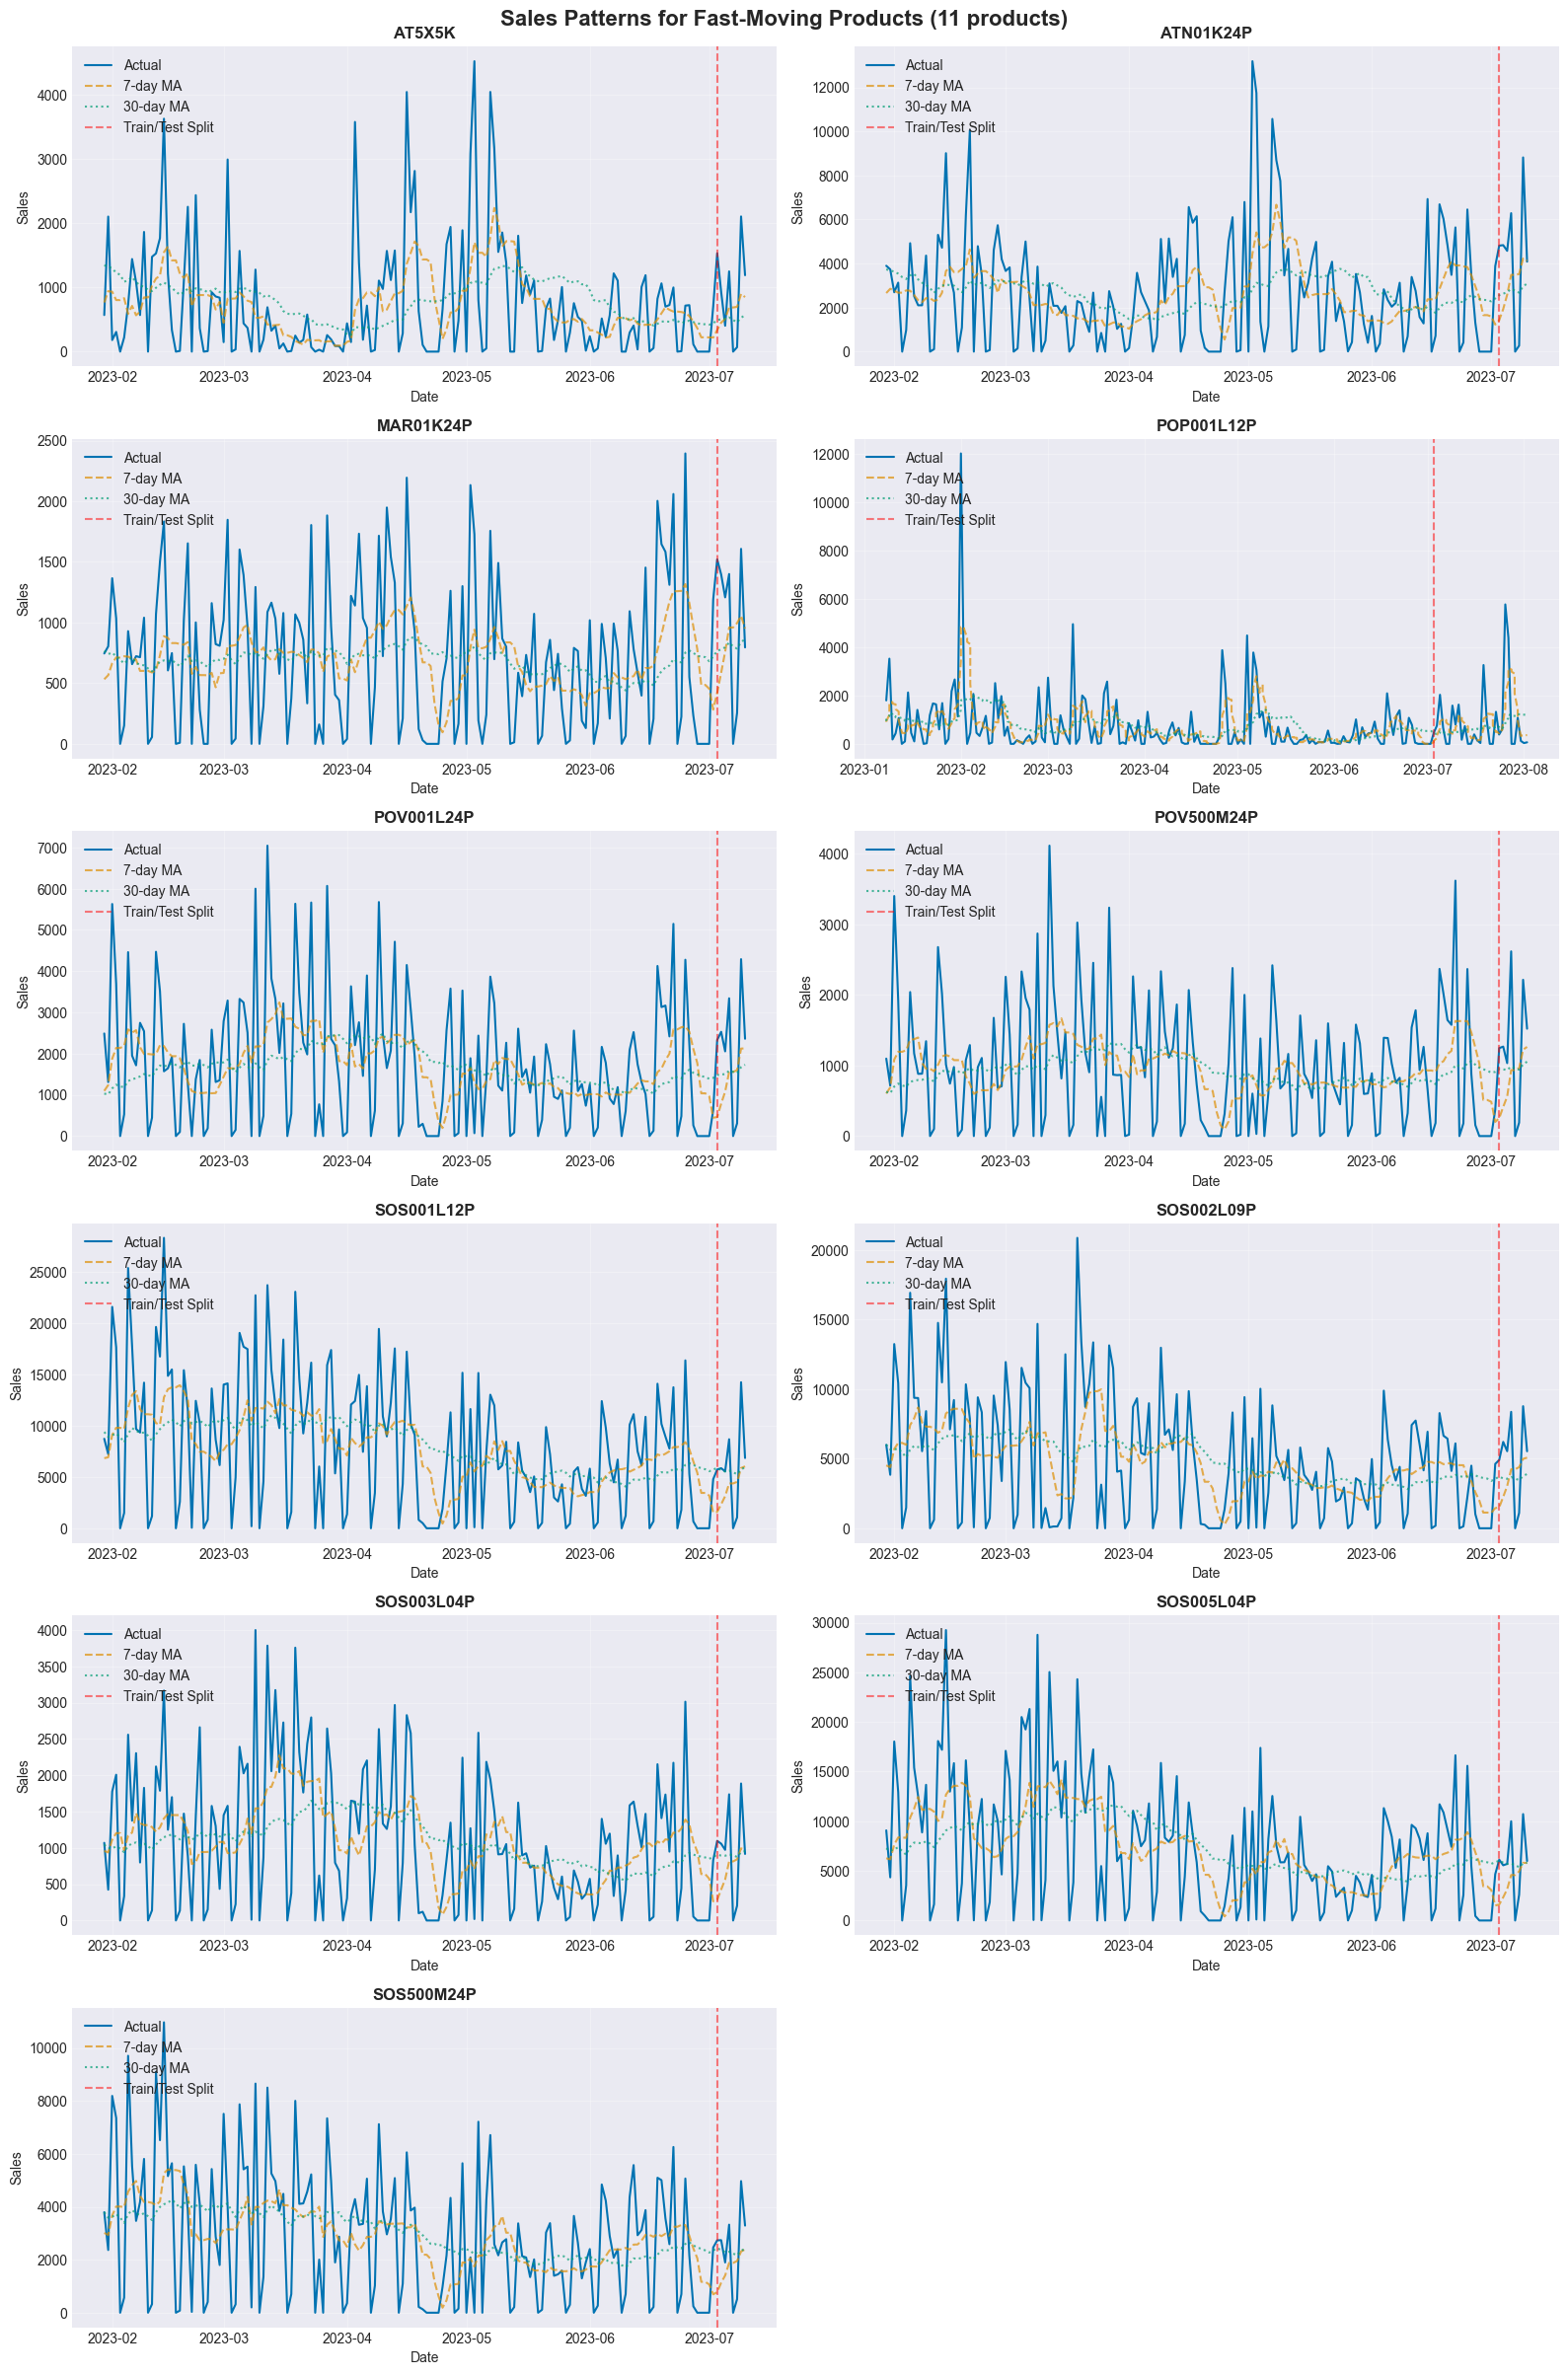

✓ Sales pattern visualization complete


In [23]:
# Plot sales patterns for fast movers
n_products = len(FAST_MOVERS)
n_cols = 2
n_rows = int(np.ceil(n_products / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, product in enumerate(FAST_MOVERS):
    if i >= len(axes):  # Safety check
        break
        
    product_data = df_clean[df_clean['Product'] == product]
    
    ax = axes[i]
    ax.plot(product_data['Date'], product_data['Sales'], label='Actual', linewidth=1.5)
    ax.plot(product_data['Date'], product_data['Sales_rolling_mean_7'], label='7-day MA', alpha=0.7, linestyle='--')
    ax.plot(product_data['Date'], product_data['Sales_rolling_mean_30'], label='30-day MA', alpha=0.7, linestyle=':')
    
    # Mark train/test split
    ax.axvline(split_date, color='red', linestyle='--', alpha=0.5, label='Train/Test Split')
    
    ax.set_title(f'{product}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Sales', fontsize=10)
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.suptitle(f'Sales Patterns for Fast-Moving Products ({n_products} products)', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

print("✓ Sales pattern visualization complete")

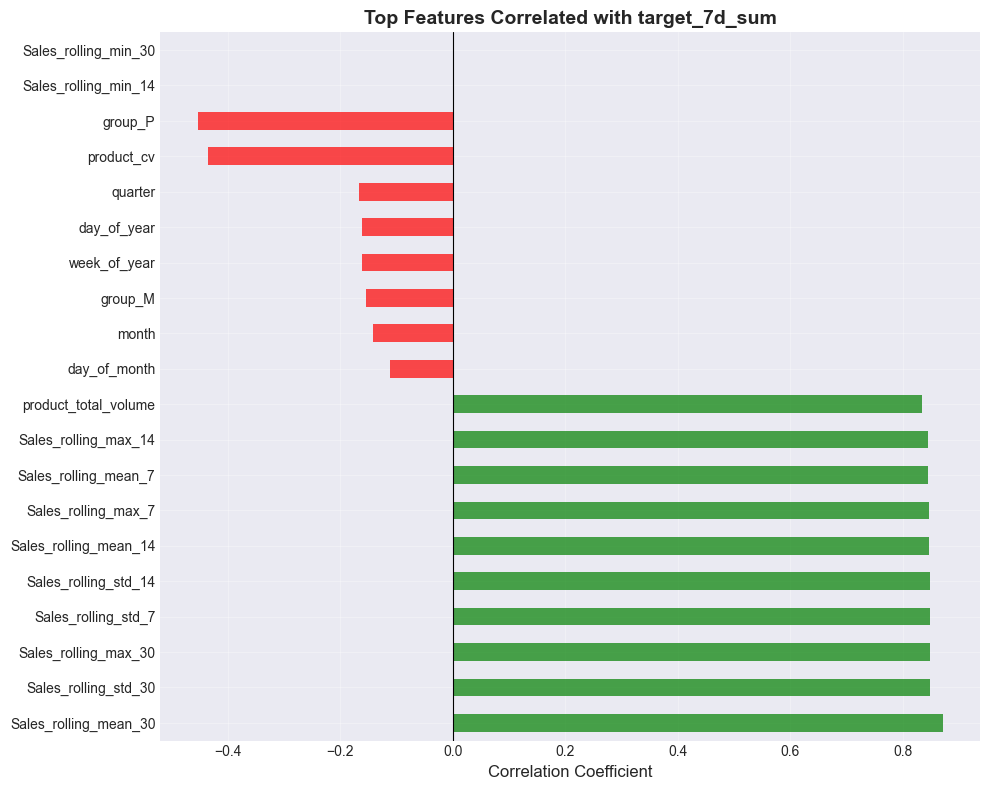

✓ Feature correlation analysis complete


In [19]:
# Simple correlation analysis with 7-day target
target_col = 'target_7d_sum'
correlations = train_df[feature_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)

# Plot top 20 most correlated features
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = pd.concat([correlations.head(10), correlations.tail(10)])
colors = ['green' if x > 0 else 'red' for x in top_20.values]
top_20.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
ax.set_title(f'Top Features Correlated with {target_col}', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Feature correlation analysis complete")

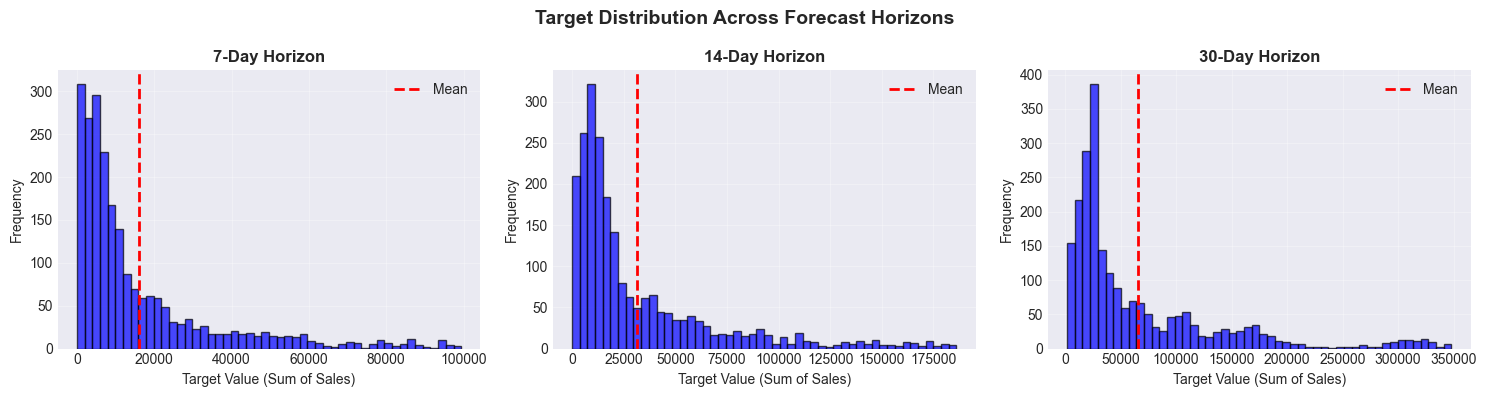

✓ Target distribution visualization complete


In [20]:
# Target distribution for each horizon
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, horizon in enumerate(FORECAST_HORIZONS):
    target_col = f'target_{horizon}d_sum'
    
    ax = axes[i]
    train_df[target_col].hist(bins=50, ax=ax, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f'{horizon}-Day Horizon', fontsize=12, fontweight='bold')
    ax.set_xlabel('Target Value (Sum of Sales)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.axvline(train_df[target_col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Target Distribution Across Forecast Horizons', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Target distribution visualization complete")

## 10. Save Processed Data

In [21]:
# Save train and test sets
train_df.to_csv('../data/processed/train_fast_movers.csv', index=False)
test_df.to_csv('../data/processed/test_fast_movers.csv', index=False)

# Save feature list
with open('../data/processed/feature_columns.txt', 'w') as f:
    for col in feature_cols:
        f.write(f"{col}\n")

# Save metadata
metadata = {
    'total_features': len(feature_cols),
    'total_products': df_clean['Product'].nunique(),
    'fast_movers': FAST_MOVERS,
    'forecast_horizons': FORECAST_HORIZONS,
    'test_size_days': TEST_SIZE_DAYS,
    'split_date': str(split_date),
    'train_size': len(train_df),
    'test_size': len(test_df),
    'date_range': f"{df_clean['Date'].min()} to {df_clean['Date'].max()}"
}

import json
with open('../data/processed/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"{'='*80}")
print(f"DATA SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"\nFiles saved to: ../data/processed/")
print(f"  - train_fast_movers.csv ({len(train_df):,} rows)")
print(f"  - test_fast_movers.csv ({len(test_df):,} rows)")
print(f"  - feature_columns.txt ({len(feature_cols)} features)")
print(f"  - metadata.json")
print(f"\n{'='*80}")
print(f"✓ FEATURE ENGINEERING PIPELINE COMPLETE!")
print(f"\nNext Steps:")
print(f"  1. Build baseline models (XGBoost, LightGBM, Random Forest)")
print(f"  2. Implement LSTM/GRU for sequence modeling")
print(f"  3. Explore Graph Neural Networks for supply chain structure")
print(f"  4. Hyperparameter tuning and cross-validation")
print(f"  5. Model ensemble and stacking")
print(f"{'='*80}")

DATA SAVED SUCCESSFULLY

Files saved to: ../data/processed/
  - train_fast_movers.csv (2,257 rows)
  - test_fast_movers.csv (188 rows)
  - feature_columns.txt (75 features)
  - metadata.json

✓ FEATURE ENGINEERING PIPELINE COMPLETE!

Next Steps:
  1. Build baseline models (XGBoost, LightGBM, Random Forest)
  2. Implement LSTM/GRU for sequence modeling
  3. Explore Graph Neural Networks for supply chain structure
  4. Hyperparameter tuning and cross-validation
  5. Model ensemble and stacking
